In [1]:

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# imprt tree
from sklearn import tree
# import metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder

In [2]:
df_raw = pd.read_csv("./labeled_data/Replaced.csv", encoding_errors="ignore", on_bad_lines='skip', sep=",", index_col=False,
                    usecols=['SessionID','Activity','anomaly'])
# change anomaly to int
df_raw['anomaly'] = df_raw['anomaly'].astype(int)
df_raw

,SessionID,Activity,anomaly
0,46,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,0
1,46,/werk_nl/werknemer/mijn_werkmap/doorgeven/mijn...,0
2,46,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_d...,0
3,46,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,0
4,46,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,0
...,...,...,...
7174929,55314751,/werk_nl/werknemer/werkmap,0
7174930,55314751,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,0
7174931,55314751,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,0
7174932,55314751,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,0


Plan:
- Het gaat om de transities tussen de verschillende activiteiten
  1. Encode alle transities
  2. Maak een dictionary met alle transities




In [3]:
def concat_and_filter(df_raw, file_name, amount_real, amount_anomalies):

    df_gen_anomalies = pd.read_csv(file_name)
    df_gen_anomalies["anomaly"] = 1
    df_raw_filtered = df_raw[df_raw["SessionID"].isin(df_raw["SessionID"].unique()[:amount_real])]
    df_gen_anomalies_filtered = df_gen_anomalies[df_gen_anomalies["SessionID"].isin(df_gen_anomalies["SessionID"].unique()[:amount_anomalies])]

    df = pd.concat([df_raw_filtered, df_gen_anomalies_filtered])
    return df

def df_one_hot_encoder(df):
    #creating instance of one-hot-encoder
    encoder = OneHotEncoder()
    
    #perform one-hot encoding on 'team' column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df[['Activity']]).toarray(), index=df.index)
    encoder_df.columns = encoder.get_feature_names(['Activity'])

    #merge one-hot encoded columns back with original DataFrame
    final_df = df.join(encoder_df)
    return final_df

def calculating_duration(df):
    #Calculating the duration of an activity by using the end time. Duration returned in minutes
    df["End_time"] = df.groupby("SessionID")["TIMESTAMP"].shift(periods=-1)
    df["Duration"] = (df["End_time"] - df["TIMESTAMP"]) / pd.offsets.Minute(1)
    return df

def make_df_for_isolation_forest(df):
    #Counting each activity in every session
    df_sum = df.groupby("SessionID").sum()
    df_sum["anomaly"] = df.groupby("SessionID")["anomaly"].max()
    return df_sum

In [4]:
#Filter to get df with only real anomalies
amount_for_filtering_real_anomalies = 0
df_only_real_anomalies = df_raw[df_raw["anomaly"] == 1]

#Make the data ready for training
df_only_anomaly_selection = df_only_real_anomalies[["SessionID", "Activity", "anomaly"]]
one_hot_encoded_df_only_anomalies = df_one_hot_encoder(df_only_anomaly_selection)
df_only_anomalies_for_training = make_df_for_isolation_forest(one_hot_encoded_df_only_anomalies)

df_only_anomalies_for_train_set = df_only_anomalies_for_training[:10]
df_only_anomalies_for_test_set = df_only_anomalies_for_training[10:]

In [6]:
#Select amount of sessions used in the dataframe
var_1_amount_real = 50000
var_1_amount_generated = 0
df_real = concat_and_filter(df_raw, "./gen_sessions/100_1000.csv", amount_real = var_1_amount_real, amount_anomalies = var_1_amount_generated)

#Filter only the normal instances. 
df_real = df_real[df_real["anomaly"] == 0]

#df_real = pd.concat([df_real, df_only_real_anomalies_filtered])

#Make the data ready for training
df_real_selection = df_real[["SessionID", "Activity", "anomaly"]]
one_hot_encoded_df_real = df_one_hot_encoder(df_real_selection)
df_real_for_training = make_df_for_isolation_forest(one_hot_encoded_df_real)

In [7]:
#Make train test split
X = df_real_for_training.drop(columns=["anomaly"])
y = df_real_for_training["anomaly"]

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#Add 10 anomalies back to the training data to make it more realistic.
X_train = pd.concat([X_train_temp, df_only_anomalies_for_train_set.drop(columns=["anomaly"])]).fillna(0)
y_train = pd.concat([y_train_temp, df_only_anomalies_for_train_set["anomaly"]])

In [9]:
X_test = pd.concat([X_test_temp, df_only_anomalies_for_test_set.drop(columns=["anomaly"])]).fillna(0)
y_test = pd.concat([y_test_temp, df_only_anomalies_for_test_set["anomaly"]])

In [12]:

# import the generated sessions:
ses_amount = 1000
base_path = f"gen_sessions/{str(ses_amount)}/"

gen_sessions_paths = [
  base_path + f'5_{ses_amount}.csv',
  base_path + f'10_{ses_amount}.csv',
  base_path + f'25_{ses_amount}.csv',
  base_path + f'50_{ses_amount}.csv',
  base_path + f'75_{ses_amount}.csv',
  base_path + f'100_{ses_amount}.csv',
  # base_path + 'an.csv',
  
  # base_path + '75_10000.csv',
  # base_path + '100_10000.csv',
]

gen_sessions/1000/5_1000.csv 10
0.5

gen_sessions/1000/5_1000.csv 20
0.5

gen_sessions/1000/5_1000.csv 50
0.5061228345056729

gen_sessions/1000/5_1000.csv 65
0.5

gen_sessions/1000/5_1000.csv 100
0.5

gen_sessions/1000/5_1000.csv 200
0.5

gen_sessions/1000/5_1000.csv 300
0.5061228345056729

gen_sessions/1000/5_1000.csv 400
0.5

gen_sessions/1000/5_1000.csv 500
0.5

gen_sessions/1000/5_1000.csv 600
0.5

gen_sessions/1000/5_1000.csv 700
0.5061228345056729

gen_sessions/1000/5_1000.csv 800
0.49994999499949994

gen_sessions/1000/5_1000.csv 900
0.5

gen_sessions/1000/5_1000.csv 1000
0.5

[10, 20, 50, 65, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] [0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0] [0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]


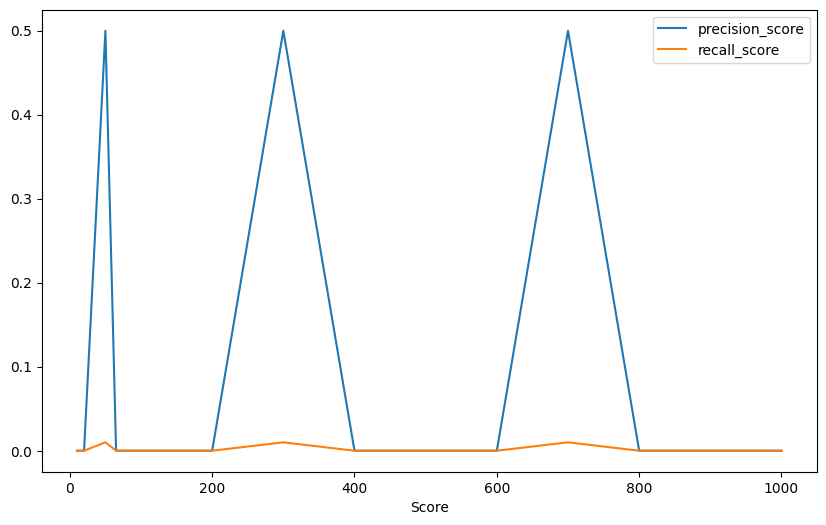

gen_sessions/1000/10_1000.csv 10
0.5

gen_sessions/1000/10_1000.csv 20
0.5

gen_sessions/1000/10_1000.csv 50
0.5

gen_sessions/1000/10_1000.csv 65
0.5

gen_sessions/1000/10_1000.csv 100
0.5061228345056729

gen_sessions/1000/10_1000.csv 200
0.5061228345056729

gen_sessions/1000/10_1000.csv 300
0.5061228345056729

gen_sessions/1000/10_1000.csv 400
0.5

gen_sessions/1000/10_1000.csv 500
0.5

gen_sessions/1000/10_1000.csv 600
0.5

gen_sessions/1000/10_1000.csv 700
0.5

gen_sessions/1000/10_1000.csv 800
0.5

gen_sessions/1000/10_1000.csv 900
0.5

gen_sessions/1000/10_1000.csv 1000
0.5

[10, 20, 50, 65, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] [0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


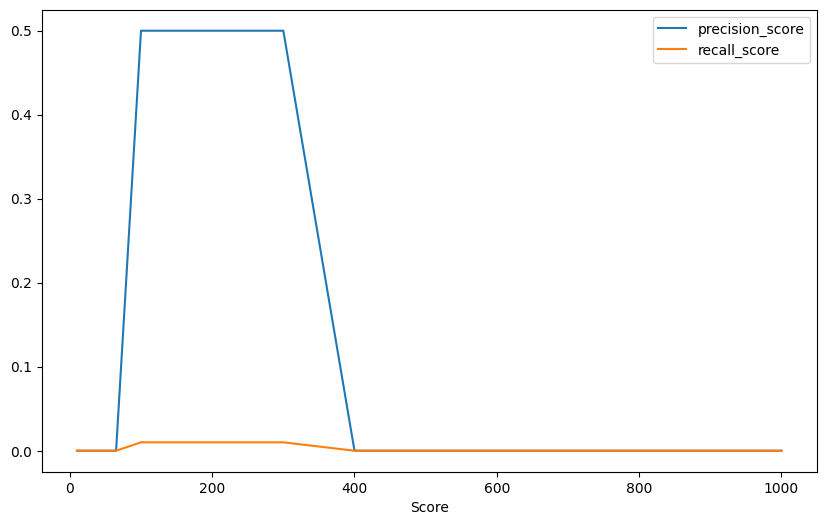

gen_sessions/1000/25_1000.csv 10
0.5

gen_sessions/1000/25_1000.csv 20
0.5061228345056729

gen_sessions/1000/25_1000.csv 50
0.5

gen_sessions/1000/25_1000.csv 65
0.49994999499949994

gen_sessions/1000/25_1000.csv 100
0.5061228345056729

gen_sessions/1000/25_1000.csv 200
0.5

gen_sessions/1000/25_1000.csv 300
0.5061228345056729

gen_sessions/1000/25_1000.csv 400
0.5061228345056729

gen_sessions/1000/25_1000.csv 500
0.5

gen_sessions/1000/25_1000.csv 600
0.5061228345056729

gen_sessions/1000/25_1000.csv 700
0.5

gen_sessions/1000/25_1000.csv 800
0.5

gen_sessions/1000/25_1000.csv 900
0.5

gen_sessions/1000/25_1000.csv 1000
0.5

[10, 20, 50, 65, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000] [0.0, 0.5, 0.0, 0.0, 0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0] [0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.01, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0]


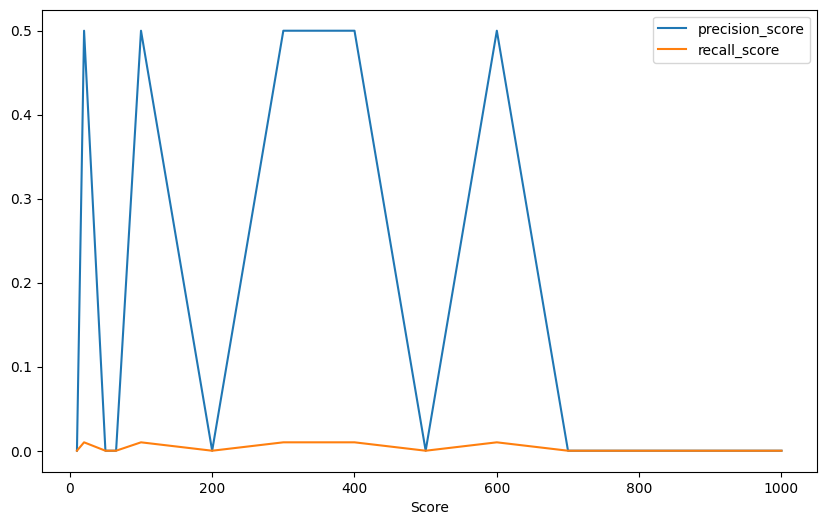

gen_sessions/1000/50_1000.csv 10
0.5

gen_sessions/1000/50_1000.csv 20
0.5

gen_sessions/1000/50_1000.csv 50
0.5

gen_sessions/1000/50_1000.csv 65
0.5

gen_sessions/1000/50_1000.csv 100
0.5

gen_sessions/1000/50_1000.csv 200
0.5

gen_sessions/1000/50_1000.csv 300
0.49994999499949994

gen_sessions/1000/50_1000.csv 400
0.5

gen_sessions/1000/50_1000.csv 500
0.5061228345056729



KeyboardInterrupt: 

In [13]:
from sklearn.preprocessing import LabelEncoder


auc_score_dicts = {}
dict_prec_and_rec_list = {}

amount_anomalies_list_total = []
precision_score_list_total = []
recall_score_list_total = []

for url in gen_sessions_paths:
    amount_anomalies_list = []
    precision_score_list = []
    recall_score_list = []

    for var_2_amount_generated in [10, 20, 50, 65, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    #[10, 100, 500, 1000, 2000]:
    #for var_2_amount_generated in [2000, 2500, 3000, 4000, 5000, 9999]:

        #Select amount of sessions used in the dataframe
        var_2_amount_real = 0

        df_generated = concat_and_filter(df_raw, url, amount_real = var_2_amount_real, amount_anomalies=var_2_amount_generated)
        #Make data ready for training
        df_generated_selection = df_generated[["SessionID", "Activity", "anomaly"]]
        one_hot_encoded_df_generated = df_one_hot_encoder(df_generated_selection)
        df_generated_for_training = make_df_for_isolation_forest(one_hot_encoded_df_generated)
        
        #Add the generated anomalies to the training dataset
        X_train_extra = pd.concat([X_train, df_generated_for_training.drop(columns=["anomaly"])]).fillna(0)
        y_train_extra = pd.concat([y_train, df_generated_for_training["anomaly"]])
        # print(y_train_extra)

        #transform y values to binary class
        Le = LabelEncoder()
        Le.fit(y_train_extra)
        y_train_transformed = Le.transform(y_train)
        y_test_transformed = Le.transform(y_test)
        y_train_extra_transformed = Le.transform(y_train_extra)

        #Make sure that both dataframes have the same columns
        for column_name in X_train_extra.columns:
            if column_name not in X_test.columns:
                X_test[column_name] = 0

        #Make sure that both dataframes have the same columns
        for column_name in X_test.columns:
            if column_name not in X_train_extra.columns:
                X_test.drop(columns=[column_name], inplace=True)
        
        clf_extra = tree.DecisionTreeClassifier().fit(X_train_extra, y_train_extra_transformed)
        # clf_extra = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_extra, y_train_extra_transformed)
        #y_train_predict = clf_extra.predict(X_train_extra)
        y_test_predict = clf_extra.predict(X_test)
        
        #AUC predict
        fpr, tpr, thresholds = metrics.roc_curve(y_test_transformed, y_test_predict)
        print(url, var_2_amount_generated)
        print(metrics.auc(fpr, tpr))
        print()
        auc_score_dicts[(url, var_2_amount_generated)] = metrics.auc(fpr, tpr)
        

        
        precision_score = [i for i in classification_report(y_test_transformed, y_test_predict).split(" ") if len(i) > 2][8]
        recall_score = [i for i in classification_report(y_test_transformed, y_test_predict).split(" ") if len(i) > 2][9]

        amount_anomalies_list.append(var_2_amount_generated)
        precision_score_list.append(precision_score)
        recall_score_list.append(recall_score)
    
    
    amount_anomalies_list = [int(i) for i in amount_anomalies_list]
    precision_score_list = [float(i) for i in precision_score_list]
    recall_score_list = [float(i) for i in recall_score_list]
    print(amount_anomalies_list, precision_score_list, recall_score_list)
    
    string_recall = "recall_" + str(url)
    string_precision = "precision_" + str(url)
    dict_prec_and_rec_list[string_recall] = recall_score_list
    dict_prec_and_rec_list[string_precision] = precision_score_list
    
    plt.figure(figsize=(10, 6))
    plt.plot(amount_anomalies_list, precision_score_list, label = "precision_score")
    plt.plot(amount_anomalies_list, recall_score_list, label = "recall_score")
    plt.xlabel("Number of anomalous sessions injected in training data")
    plt.xlabel("Score")
    # save_string = "prec_rec_scores/" + str(url.split(".")[0].split("/")[1] + url.split(".")[0].split("/")[2]) + ".png"    
    plt.legend()
    # plt.savefig(save_string)
    plt.show()